In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import os
import statsmodels.formula.api as smf


In [2]:

def load_production_data():
    print("Cargando datos de producción artesanal entre 2013 y 2023 en peru...")
    df = pd.read_csv('../data/imarpe/processed/produccion_mensual_matrix.csv')
    df['FECHA'] = pd.to_datetime(df['FECHA'])
    df.set_index('FECHA', inplace=True)
    df_long = (
        df
        .reset_index()                      # FECHA pasa de índice a columna
        .melt(
            id_vars="FECHA",
            var_name="puerto_especie",
            value_name="valor"
        )
    )

    df_long[["puerto", "especie"]] = df_long["puerto_especie"].str.split("_", expand=True)

    df_long = df_long.drop(columns="puerto_especie")

    return df_long

def add_port_coordinates(df_long, coordinates_file):
    print("Agregando coordenadas de puertos en el dataframe de pesca artesanal...")
    coordenadas = pd.read_csv(coordinates_file)
    coordenadas = coordenadas.rename(columns={"LATITUD": "lat", "LONGITUD": "lon", "PUERTO": "puerto"})
    coordenadas["puerto"] = coordenadas["puerto"].astype(str).str.strip().str.upper()
    df_long["puerto"] = df_long["puerto"].astype(str).str.strip().str.upper()

    df_long_geo = df_long.merge(
        coordenadas[["puerto", "lat", "lon"]],
        on="puerto",
        how="left"
    )
    
    return df_long_geo

def load_nearest_sst_data(df_long_geo, type='mean'):
    print("Cargando datos de SST y asignando al dataframe de pesca artesanal...")

    if type == 'mean':
        ds_sst = xr.open_dataset('../data/MODIS/processed/sst_anomaly_monthly_2002_2025.nc')
    elif type == 'max':
        ds_sst = xr.open_dataset('../data/MODIS/processed/sst_anomaly_monthly_max_2002_2025.nc')
    elif type == 'sum':
        ds_sst = xr.open_dataset('../data/MODIS/processed/sst_anomaly_monthly_sum_2002_2025.nc')

    df_sst = ds_sst.sel(lon=df_long_geo['lon'], lat=df_long_geo['lat'], method="nearest")
    df_sst = df_sst.to_dataframe().reset_index()
    df_sst = df_sst.rename(columns={"time": "FECHA"})

    df_long_geo = df_long_geo.merge(df_sst, on="FECHA", how="left")

    return df_long_geo


def find_valid_modis_pixel(
    ds_sst,
    lat_puerto,
    lon_puerto,
    search_radius=0.5,
    min_valid_frac=0.7
):
    lat_vals = ds_sst["lat"].values
    lon_vals = ds_sst["lon"].values

    lat_mask = np.abs(lat_vals - lat_puerto) <= search_radius
    lon_mask = np.abs(lon_vals - lon_puerto) <= search_radius

    candidate_lats = lat_vals[lat_mask]
    candidate_lons = lon_vals[lon_mask]

    results = []

    for lat in candidate_lats:
        for lon in candidate_lons:
            ts = ds_sst["sst"].sel(lat=lat, lon=lon)

            valid_frac = ts.notnull().mean().item()

            if valid_frac >= min_valid_frac:
                dist = np.sqrt((lat - lat_puerto)**2 + (lon - lon_puerto)**2)

                results.append({
                    "lat": lat,
                    "lon": lon,
                    "valid_frac": valid_frac,
                    "distance": dist
                })

    if len(results) == 0:
        return None

    results = sorted(results, key=lambda x: x["distance"])
    return results[0]

In [3]:
df_long = load_production_data()
df_long_geo = add_port_coordinates(df_long, "../data/imarpe/processed/coordenadas_puertos.csv")
ds_sst = xr.open_dataset('../data/MODIS/processed/sst_anomaly_monthly_2002_2025.nc')

Cargando datos de producción artesanal entre 2013 y 2023 en peru...
Agregando coordenadas de puertos en el dataframe de pesca artesanal...


In [4]:
puertos = (
    df_long_geo[["puerto", "lat", "lon"]]
    .drop_duplicates()
    .reset_index(drop=True)
)


In [5]:
# pixel_por_puerto = []

# for _, row in puertos.iterrows():
#     res = find_valid_modis_pixel(
#         ds_sst,
#         lat_puerto=row["lat"],
#         lon_puerto=row["lon"],
#         search_radius=0.5,
#         min_valid_frac=0.7
#     )

#     if res is None:
#         pixel_por_puerto.append({
#             "puerto": row["puerto"],
#             "lat_puerto": row["lat"],
#             "lon_puerto": row["lon"],
#             "lat_modis": np.nan,
#             "lon_modis": np.nan,
#             "distance_deg": np.nan,
#             "valid_frac": np.nan
#         })
#     else:
#         pixel_por_puerto.append({
#             "puerto": row["puerto"],
#             "lat_puerto": row["lat"],
#             "lon_puerto": row["lon"],
#             "lat_modis": res["lat"],
#             "lon_modis": res["lon"],
#             "distance_deg": res["distance"],
#             "valid_frac": res["valid_frac"]
#         })

# df_pixel_modis = pd.DataFrame(pixel_por_puerto)


In [6]:
def load_sst_using_valid_pixels_monthly(df_long_geo, df_pixel_modis, type="mean"):
    if type == "mean":
        ds_sst = xr.open_dataset("../data/MODIS/processed/sst_anomaly_monthly_2002_2025.nc")
    elif type == "max":
        ds_sst = xr.open_dataset("../data/MODIS/processed/sst_anomaly_monthly_max_2002_2025.nc")
    elif type == "sum":
        ds_sst = xr.open_dataset("../data/MODIS/processed/sst_anomaly_monthly_sum_2002_2025.nc")

    df = df_long_geo.copy()

    df["puerto"] = df["puerto"].astype(str).str.strip().str.upper()
    px = df_pixel_modis.copy()
    px["puerto"] = px["puerto"].astype(str).str.strip().str.upper()

    df["FECHA"] = pd.to_datetime(df["FECHA"])
    df["anio_mes"] = df["FECHA"].dt.to_period("M").astype(str)

    df = df.merge(
        px[["puerto", "lat_modis", "lon_modis", "valid_frac", "distance_deg"]],
        on="puerto",
        how="left"
    )

    puertos_validos = (
        px.dropna(subset=["lat_modis", "lon_modis"])[["puerto", "lat_modis", "lon_modis"]]
        .drop_duplicates()
        .reset_index(drop=True)
    )

    sst_rows = []
    for _, r in puertos_validos.iterrows():
        da = ds_sst["sst"].sel(lat=r["lat_modis"], lon=r["lon_modis"])
        tmp = da.to_dataframe(name="sst_anom").reset_index()
        tmp = tmp.rename(columns={"time": "FECHA"})
        tmp["FECHA"] = pd.to_datetime(tmp["FECHA"])
        tmp["anio_mes"] = tmp["FECHA"].dt.to_period("M").astype(str)
        tmp["puerto"] = r["puerto"]
        sst_rows.append(tmp[["puerto", "anio_mes", "sst_anom"]])

    df_sst = pd.concat(sst_rows, ignore_index=True).drop_duplicates(subset=["puerto", "anio_mes"])

    df = df.merge(df_sst, on=["puerto", "anio_mes"], how="left")

    return df

In [7]:
# df_pixel_modis.to_csv('../data/imarpe/processed/pixeles_modis_asignados_a_puertos_artesanales.csv', index=False)
df_pixel_modis = pd.read_csv('../data/imarpe/processed/pixeles_modis_asignados_a_puertos_artesanales.csv')

In [ ]:
types = ['sum', 'mean', 'max']

for i in types:
    df_final = load_sst_using_valid_pixels_monthly(df_long_geo, df_pixel_modis, type=i)



    list_ports_ok = df_final.groupby(['puerto'])['valor'].sum().sort_values(ascending=False).head(10)
    print(list_ports_ok.index)

    zero_stats = (
        df_long_geo
        .groupby("especie")["valor"]
        .apply(lambda x: (x == 0).mean())
        .reset_index(name="frac_zeros")
        .sort_values("frac_zeros")
    )

    for i in range(7):
        especie_sel = zero_stats.iloc[i]["especie"]
        print(especie_sel)
        min_obs = 12 * 6

        df_e = df_final[df_final["especie"] == especie_sel].copy()
        df_e = df_e[df_e["valor"] > 0]

        df_e = df_e[df_e["puerto"].isin(list_ports_ok.index)]

        counts = df_e.groupby("puerto").size()
        puertos_ok = counts[counts >= min_obs].index
        df_e = df_e[df_e["puerto"].isin(puertos_ok)]

        if df_e.empty or df_e["puerto"].nunique() < 2:
            print("  Salteo: datos insuficientes tras mínimo de observaciones")
            continue

        df_e["log_valor"] = np.log(df_e["valor"])

        model = smf.ols(
            "log_valor ~ sst_anom + C(puerto)",
            data=df_e
        ).fit(cov_type="HC1")


        coef_table = model.summary2().tables[1]
        sst_row = coef_table.loc["sst_anom"]
        sst_df = sst_row.to_frame(name="sst_anom").T
        print(sst_df)

In [149]:
rows = []
types = ["mean", "max", 'sum']

zero_stats = (
    df_long_geo
    .groupby("especie")["valor"]
    .apply(lambda x: (x == 0).mean())
    .reset_index(name="frac_zeros")
    .sort_values("frac_zeros")
)

for t in types:
    df_final = load_sst_using_valid_pixels_monthly(
        df_long_geo, df_pixel_modis, type=t
    )

    list_ports_ok = (
        df_final.groupby("puerto")["valor"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )

    for i in range(7):
        especie_sel = zero_stats.iloc[i]["especie"]
        min_obs = 12 * 6

        df_e = df_final[df_final["especie"] == especie_sel].copy()
        df_e = df_e[df_e["valor"] > 0]
        df_e = df_e[df_e["puerto"].isin(list_ports_ok.index)]

        counts = df_e.groupby("puerto").size()
        puertos_ok = counts[counts >= min_obs].index
        df_e = df_e[df_e["puerto"].isin(puertos_ok)]

        if df_e.empty or df_e["puerto"].nunique() < 2:
            continue

        df_e["log_valor"] = np.log(df_e["valor"])

        model = smf.ols(
            "log_valor ~ sst_anom + C(puerto)",
            data=df_e
        ).fit(cov_type="HC1")

        rows.append({
            "especie": especie_sel,
            "type": t,
            "coef": model.params["sst_anom"].round(4),
            "pvalue": model.pvalues["sst_anom"].round(4),
        })

long_df = pd.DataFrame(rows)

wide_df = (
    long_df
    .pivot(index="especie", columns="type", values=["coef", "pvalue"])
    .reindex(columns=["max", "mean", "sum"], level=1)
)

wide_df.columns = [f"{t}_{m}" for m, t in wide_df.columns]
wide_df = wide_df.reset_index()

wide_df


,especie,max_coef,mean_coef,sum_coef,max_pvalue,mean_pvalue,sum_pvalue
0,BONITO,0.1031,-0.0272,-0.0272,0.0429,0.6342,0.6342
1,CABALLA,-0.0811,-0.1014,-0.1014,0.0686,0.0532,0.0532
2,JUREL,-0.1246,-0.1401,-0.1401,0.0580,0.0497,0.0497
3,LISA,-0.0045,0.0227,0.0227,0.9023,0.5793,0.5793
4,MERLUZA,-0.1987,-0.3165,-0.3165,0.0080,0.0001,0.0001
5,PERICO,0.0169,-0.1342,-0.1342,0.8435,0.1289,0.1289
6,POTA,-0.0059,-0.0008,-0.0008,0.8951,0.9865,0.9865


In [150]:
sum_df = wide_df[[
    "especie",
    "sum_coef",
]]

sum_df


,especie,sum_coef
0,BONITO,-0.0272
1,CABALLA,-0.1014
2,JUREL,-0.1401
3,LISA,0.0227
4,MERLUZA,-0.3165
5,PERICO,-0.1342
6,POTA,-0.0008


(-30.0, 10.0)

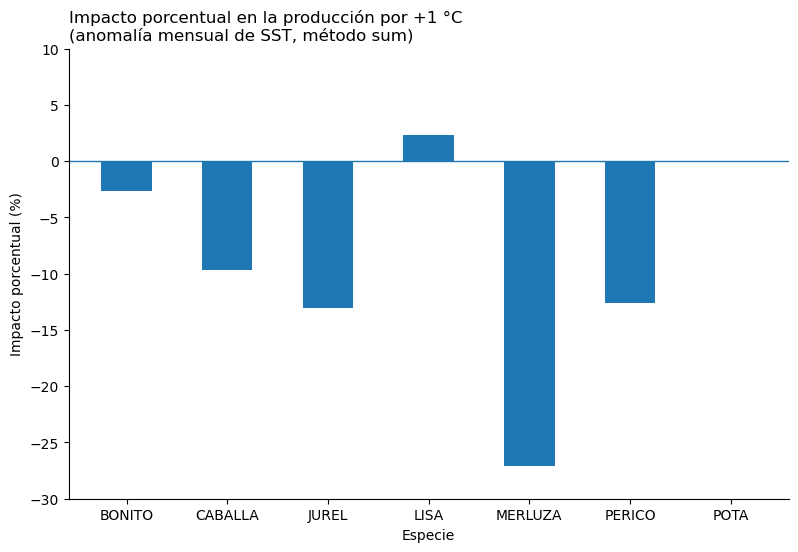

In [151]:
import numpy as np
import matplotlib.pyplot as plt

sum_df = sum_df.copy()
sum_df["impacto_pct"] = 100 * (np.exp(sum_df["sum_coef"]) - 1)

fig = plt.figure(figsize=(8, 5))
ax = plt.axes([0.05, 0.05, 0.9, 0.9])
ax.bar(sum_df["especie"], sum_df["impacto_pct"], width=0.5)
ax.axhline(0, linewidth=1)

ax.set_ylabel("Impacto porcentual (%)")
ax.set_xlabel("Especie")
ax.set_title("Impacto porcentual en la producción por +1 °C\n(anomalía mensual de SST, método sum)", loc="left")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(-30, 10)


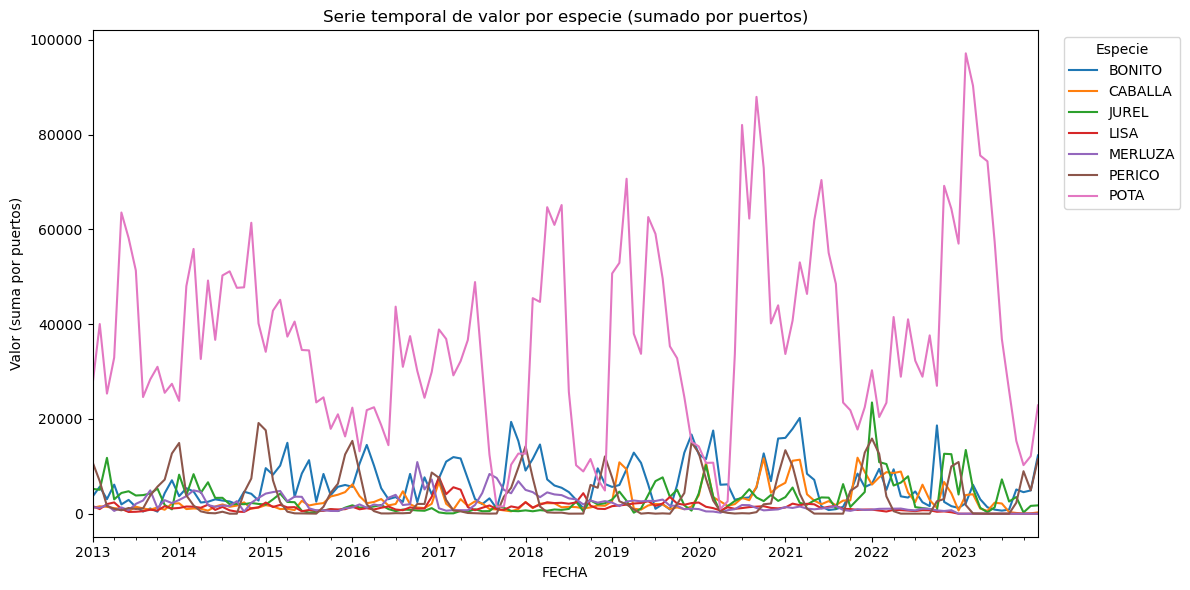

In [152]:
ts = (
    df_final
    .groupby(['FECHA', 'especie'])['valor']
    .sum()
    .reset_index()
)

ts_pivot = ts.pivot(index='FECHA', columns='especie', values='valor').sort_index()

ts_pivot.plot(figsize=(12,6))
plt.ylabel('Valor (suma por puertos)')
plt.title('Serie temporal de valor por especie (sumado por puertos)')
plt.legend(title='Especie', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

In [154]:
prod_promedio = (
    ts
    .groupby("especie")["valor"]
    .mean()
    .reset_index(name="produccion_promedio_mensual")
)

prod_promedio = prod_promedio.sort_values(
    "produccion_promedio_mensual",
    ascending=False
)

prod_promedio


,especie,produccion_promedio_mensual
6,POTA,36502.988046
0,BONITO,6296.255273
5,PERICO,3712.328016
2,JUREL,3180.853299
1,CABALLA,2889.490980
4,MERLUZA,2045.313916
3,LISA,1370.357012


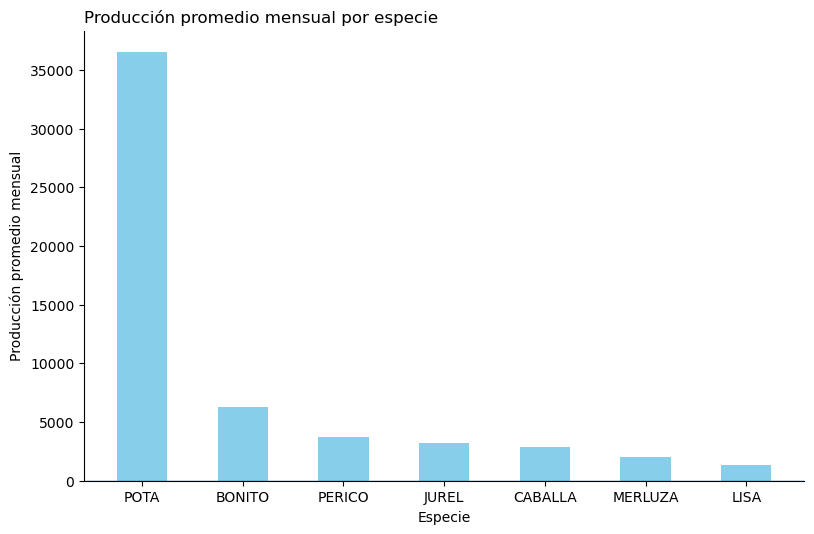

In [156]:

fig = plt.figure(figsize=(8, 5))
ax = plt.axes([0.05, 0.05, 0.9, 0.9])
ax.bar(prod_promedio["especie"], prod_promedio["produccion_promedio_mensual"], width=0.5, color='skyblue')
ax.axhline(0, linewidth=1)

ax.set_ylabel("Producción promedio mensual")
ax.set_xlabel("Especie")
ax.set_title("Producción promedio mensual por especie", loc="left")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
